In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from math import sqrt
import datetime
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


In [121]:

# Read the CSV file
mass_df = pd.read_csv("sample_data/mass_shootings_merged_data.csv")

# Convert the 'date' column to datetime
mass_df['date'] = pd.to_datetime(mass_df['date'])

# Extract the 'year' from the 'date' column
mass_df['year'] = mass_df['date'].dt.year

# Calculate the case count per year
count_per_year = mass_df.groupby('year').size().reset_index(name='case count per year')

# Merge the case count per year into the main DataFrame
mass_df = mass_df.merge(count_per_year, on='year')

# Create a new DataFrame with 'year' and 'case count per year' columns
casecount_df = mass_df[['year', 'case count per year']].drop_duplicates().sort_values(by='year')

# Export ned_df to csv file
casecount_df.to_csv('case_count_instances.csv', index=False)

# Display the first few rows of the new DataFrame
casecount_df.head()


,year,case count per year
140,1982,1
138,1984,2
137,1986,1
136,1987,1
135,1988,1


In [122]:
# Create a new DataFrame with total victims and total laws column
df = mass_df[['date','total_victims', 'total_laws']].dropna().set_index('date').sort_index()
df.info()
#display the first few rows of the dataframe
df.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106 entries, 1991-01-11 to 2019-12-10
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   total_victims  106 non-null    int64  
 1   total_laws     106 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 2.5 KB


,total_victims,total_laws
date,,
1991-01-11,7,19.0
1991-10-16,44,13.0
1991-11-14,10,24.0
1992-01-05,14,57.0
1992-10-15,5,34.0


**Identification**
- plot the time series
- use augumented Dicky-Fuller test (ADF)
- Use transforms and/or differencing if the data is non-stationary
- Plot ACF/PACF

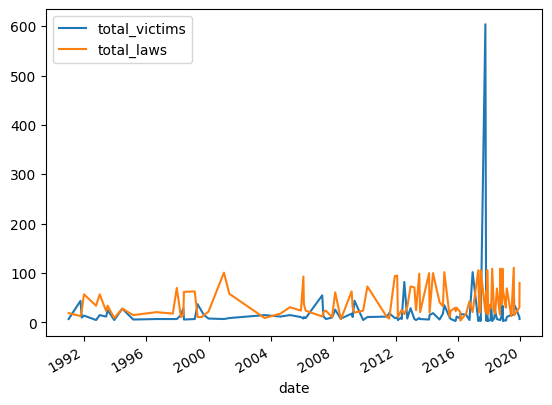

In [123]:
df.plot()
plt.show()


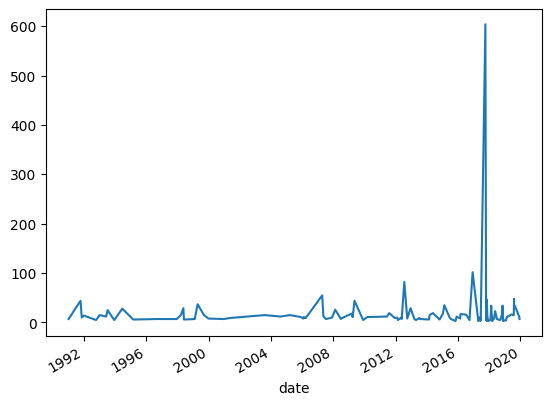

In [124]:
df['total_victims'].plot()
plt.show()


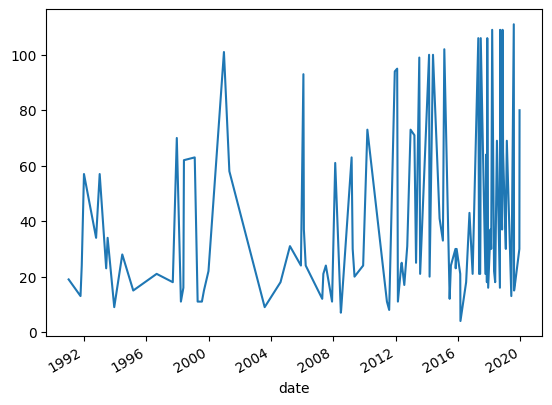

In [125]:
df['total_laws'].plot()
plt.show()


**Other transformation**
- Not necessary for the model because the ARIMA model still produce thee same ooutcome without the transformation

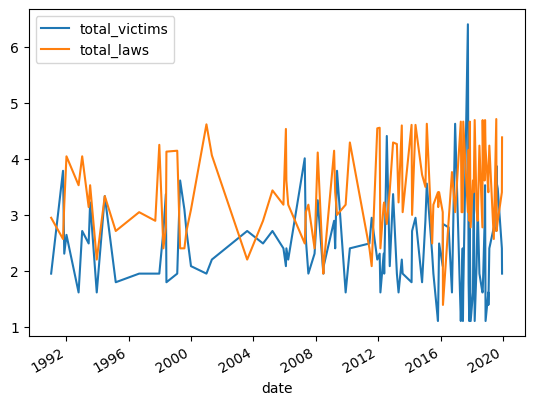

In [126]:
df_log = np.log(df)
df_log.plot()
plt.show()

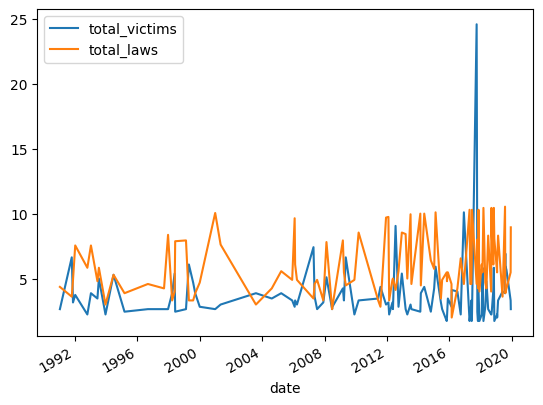

In [127]:
df_sqrt = np.sqrt(df)
df_sqrt.plot()
plt.show()

**Test for trend stationarity using augumented Dicker Fuller test**

In [128]:
# statistical test for trend stationarity

result = adfuller(df['total_victims'])
# print test statistic
print(result[0])
# print p-value
print(result[1])
#print critical values
print(result[4])

-10.636131173835533
5.066888415117094e-19
{'1%': -3.4942202045135513, '5%': -2.889485291005291, '10%': -2.5816762131519275}


The p value is less than 0.05 and test statistics element is a negative which indicates stationarity

In [129]:
# statistical test for trend stationarity
result_2 = adfuller(df['total_laws'])
# print test statistic
print(result_2[0])
# print p-value
print(result_2[1])
#print critical values
print(result_2[4])

-11.497718181966242
4.570896892146305e-21
{'1%': -3.4942202045135513, '5%': -2.889485291005291, '10%': -2.5816762131519275}


The time series does lack trend and seasonality, therefore it is stationary and not necessary to apply other transformative steps.

The test statisitc values for total_laws and total_victims are negative values and p_values are less than 0.05 or 5%, indicating statistical significance



/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


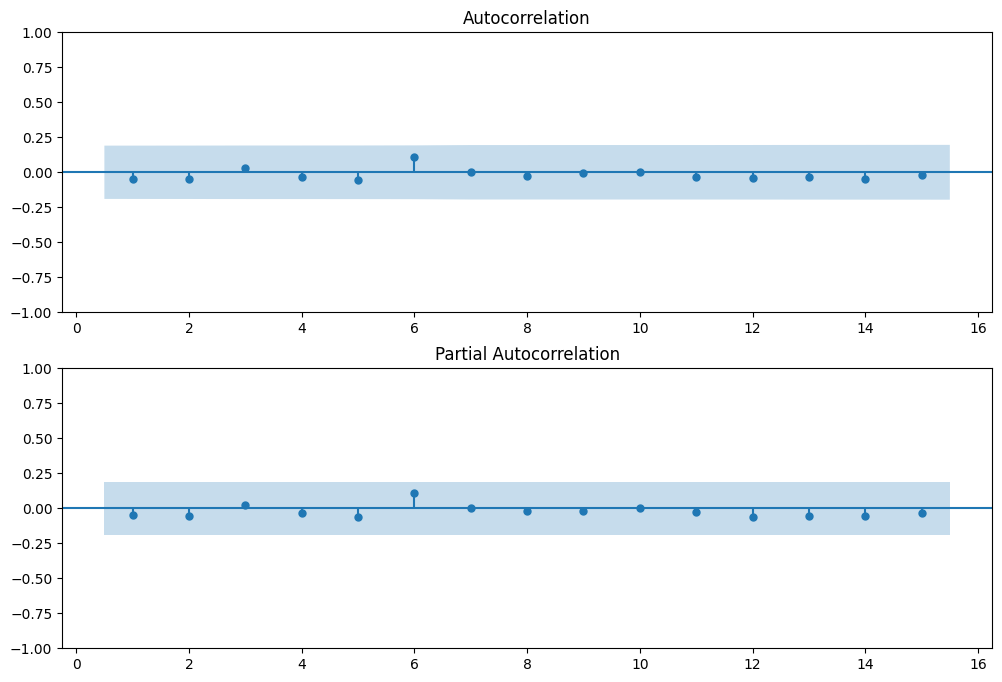

In [130]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of savings on ax1
plot_acf(df['total_victims'],lags=15, zero=False, ax=ax1)

# Plot the PACF of savings on ax2
plot_pacf(df['total_victims'],lags=15, zero=False, ax=ax2)

plt.show()

**Train-test split**

In [131]:
test_size = round(len(df) * 0.20)
train = df[:-test_size]
test = df[-test_size:]

train.info()
test.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85 entries, 1991-01-11 to 2018-01-28
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   total_victims  85 non-null     int64  
 1   total_laws     85 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 2.0 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21 entries, 2018-02-14 to 2019-12-10
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   total_victims  21 non-null     int64  
 1   total_laws     21 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 504.0 bytes


**OR**

In [132]:
# Train data - all data up to the end of 2012
#train = df.loc[:'2012']

# Test data - all data from 2013 onwards
#test = df.loc['2013':]

**Finding promising p and q model order**

In [133]:
order_aic_bic = []
# Loop over p values from 0-3
for p in range(4):
  
  # Loop over q values from 0-3
    for q in range(4):
      try:
        # Create and fit ARMA(p,q) model
        model = ARIMA(train['total_victims'], order=(p,0,q),exog=train['total_laws'])
        results = model.fit()
        
        # Print p, q, AIC, BIC
        order_aic_bic.append((p, q, results.aic, results.bic))
        
      except:
        print(p, q, None, None)

order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'aic', 'bic'])

#sort by AIC
print(order_df.sort_values('aic'))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


    p  q         aic         bic
0   0  0  957.367239  964.695192
1   0  1  959.323831  969.094436
4   1  0  959.330717  969.101322
2   0  2  961.071965  973.285221
8   2  0  961.072650  973.285907
5   1  1  961.215710  973.428966
9   2  1  963.061799  977.717706
12  3  0  963.063346  977.719253
6   1  2  963.064952  977.720859
3   0  3  963.066093  977.722000
10  2  2  964.471245  981.569804
11  2  3  964.509614  984.050824
13  3  1  965.061500  982.160059
7   1  3  965.066052  982.164611
14  3  2  966.601958  986.143168
15  3  3  967.906282  989.890143


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [134]:
order_df.sort_values('aic').head()

,p,q,aic,bic
0,0,0,957.367239,964.695192
1,0,1,959.323831,969.094436
4,1,0,959.330717,969.101322
2,0,2,961.071965,973.285221
8,2,0,961.072650,973.285907


**Fitting an ARMAX model**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


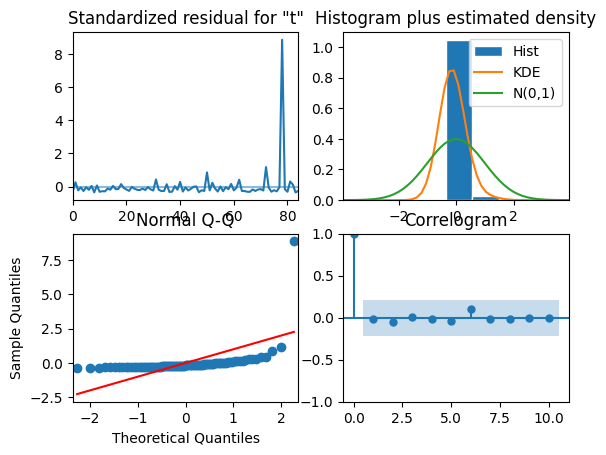

                               SARIMAX Results                                
Dep. Variable:          total_victims   No. Observations:                   85
Model:                          ARIMA   Log Likelihood                -475.684
Date:                Mon, 05 Jun 2023   AIC                            957.367
Time:                        03:58:41   BIC                            964.695
Sample:                             0   HQIC                           960.315
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.8096     47.200      0.632      0.528     -62.700     122.320
total_laws    -0.2130      1.441     -0.148      0.883      -3.038       2.612
sigma2      4249.9811    467.148      9.098      0.0

In [135]:
# Create and fit ARMAX model
model = ARIMA(train['total_victims'], order=(0,0,0), exog=train['total_laws'])
results = model.fit()

# Create the 4 diagostics plots
results.plot_diagnostics()
plt.show()

# Print summary
print(results.summary())

**Forecasting in sample**
- Let's see how the model does on the test set!

**Plotting your predicted value**

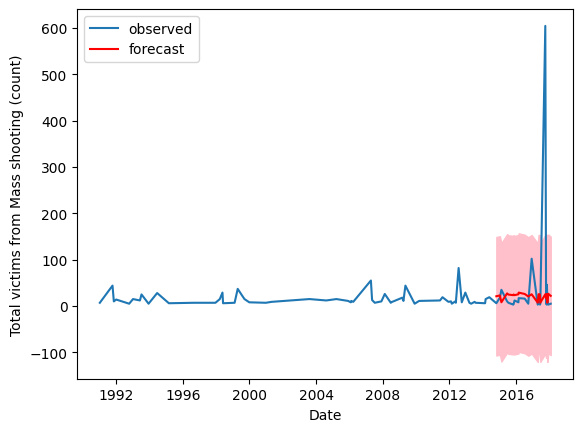

In [136]:
# Generate predictions
dynamic_forecast = results.get_prediction(start=-25, dynamic=True)

# Extract prediction mean
mean_forecast = dynamic_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = dynamic_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower total_victims']
upper_limits = confidence_intervals.loc[:,'upper total_victims']

# plot the mass_shootings data
plt.plot(train.index, train['total_victims'], label='observed')

# plot your mean forecast
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, 
         upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Total victims from Mass shooting (count)')
plt.legend()
plt.show()

**Forecast out sample**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


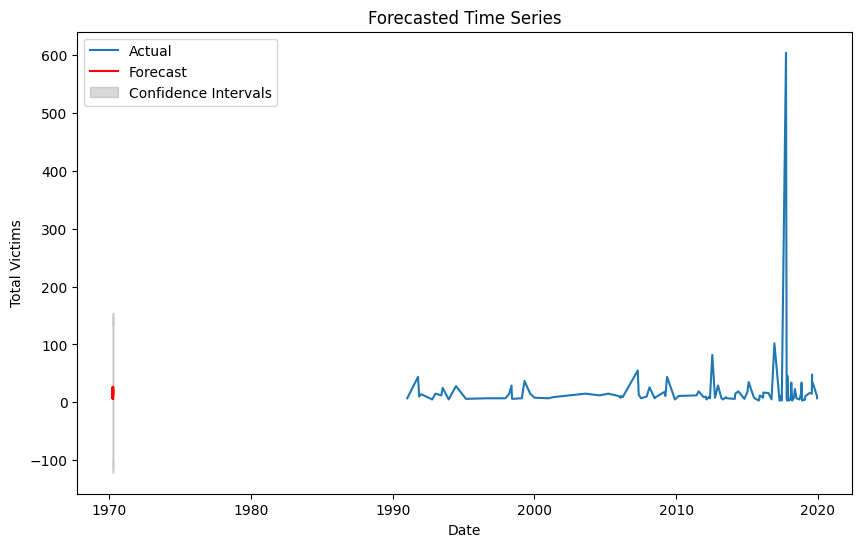

In [137]:

# Forecasting out of sample
exog_values = test['total_laws']
total_victim_forecast = results.get_forecast(steps=len(test), exog=exog_values)

# Extract prediction mean
mean_forecast_os = total_victim_forecast.predicted_mean

# Get confidence intervals of predictions# plot the mass_shootings data
confidence_intervals_os = total_victim_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits_os = confidence_intervals_os.loc[:, 'lower total_victims']
upper_limits_os = confidence_intervals_os.loc[:, 'upper total_victims']

# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['total_victims'], label='Actual')
plt.plot(mean_forecast_os.index, mean_forecast_os, color='red', label='Forecast')
plt.fill_between(mean_forecast_os.index, lower_limits_os, upper_limits_os, color='gray', alpha=0.3, label='Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Total Victims')
plt.title('Forecasted Time Series')
plt.legend()
plt.show()
